# Import Required Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0,ResNet50  # or use DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Preprocess the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hard coded Model

In [3]:
# Function to preprocess images
def preprocess_image(image, label):
    image = tf.image.resize(image, (256, 256)) / 255.0
    return image, label

# Function to select 2000 samples
def prepare_limited_dataset(directory, batch_size=32, img_size=(256, 256), sample_size=2000):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='binary',
        shuffle=True
    )

    # Convert dataset to NumPy arrays
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.extend(img_batch.numpy())
        labels.extend(label_batch.numpy())
        if len(images) >= sample_size:
            break

    images = np.array(images[:sample_size])
    labels = np.array(labels[:sample_size])

    return tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

# Load limited dataset (2000 samples)
train_ds = prepare_limited_dataset('/content/drive/MyDrive/chest_xray/train', sample_size=2000)
val_ds = prepare_limited_dataset('/content/drive/MyDrive/chest_xray/val', sample_size=500)
test_data = prepare_limited_dataset('/content/drive/MyDrive/chest_xray/test', sample_size=500)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [4]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_hard = cnn_model.fit(train_ds, validation_data=val_ds, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.6572 - loss: 320.9207 - val_accuracy: 0.7500 - val_loss: 0.4497
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9467 - loss: 0.1562 - val_accuracy: 0.6250 - val_loss: 0.9743
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9495 - loss: 0.1305 - val_accuracy: 0.6875 - val_loss: 0.5499
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9769 - loss: 0.0658 - val_accuracy: 1.0000 - val_loss: 0.1096
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9849 - loss: 0.0505 - val_accuracy: 0.7500 - val_loss: 0.5369


# Pre-Trained Model

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Pretrained EfficientNetB0 Model (Feature Extractor)
base_model = keras.applications.EfficientNetB0(weights="imagenet", include_top=False)

# Add Global Average Pooling & Classifier
avg = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(1, activation="sigmoid")(avg)  # Binary classification → Sigmoid

# Create Model
model = keras.Model(inputs=base_model.input, outputs=output)

# Freeze Base Model Layers (Feature Extractor)
for layer in base_model.layers:
    layer.trainable = False


In [6]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)

model.compile(loss="binary_crossentropy",  # Binary classification loss
              optimizer=optimizer,
              metrics=["accuracy"])

history_pretrained = model.fit(train_ds, epochs=5, validation_data=val_ds)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 348ms/step - accuracy: 0.8355 - loss: 0.5795 - val_accuracy: 0.6875 - val_loss: 0.6835
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9165 - loss: 0.3485 - val_accuracy: 0.9375 - val_loss: 0.1043
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9440 - loss: 0.2866 - val_accuracy: 0.8125 - val_loss: 0.4081
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9615 - loss: 0.1398 - val_accuracy: 0.9375 - val_loss: 0.0786
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9631 - loss: 0.1031 - val_accuracy: 1.0000 - val_loss: 0.0341


In [7]:
import matplotlib.pyplot as plt

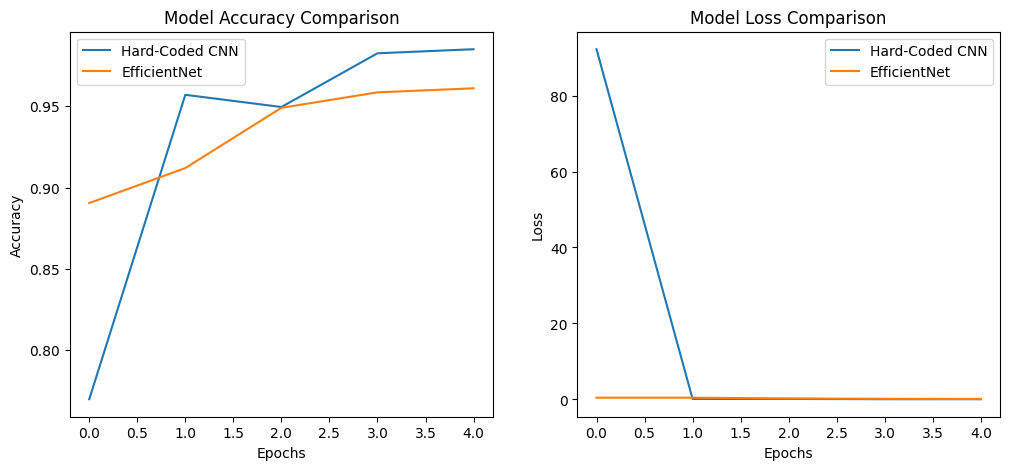

In [8]:
def plot_comparison(history_hard, history_pretrained):
    plt.figure(figsize=(12,5))

    # Accuracy Comparison
    plt.subplot(1,2,1)
    plt.plot(history_hard.history['accuracy'], label="Hard-Coded CNN")
    plt.plot(history_pretrained.history['accuracy'], label="EfficientNet")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.legend()

    # Loss Comparison
    plt.subplot(1,2,2)
    plt.plot(history_hard.history['loss'], label="Hard-Coded CNN")
    plt.plot(history_pretrained.history['loss'], label="EfficientNet")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Model Loss Comparison")
    plt.legend()

    plt.show()

# Call the function to plot
plot_comparison(history_hard, history_pretrained)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step

📊 Performance Metrics for Hard-Coded CNN:
              precision    recall  f1-score   support

         0.0       0.98      0.30      0.46       199
         1.0       0.68      1.00      0.81       301

    accuracy                           0.72       500
   macro avg       0.83      0.65      0.64       500
weighted avg       0.80      0.72      0.67       500



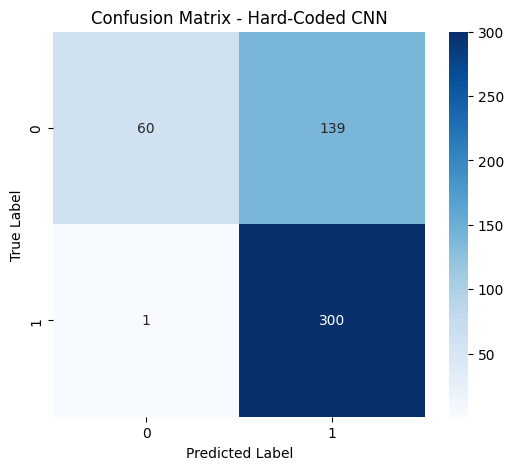

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 644ms/step

📊 Performance Metrics for EfficientNet:
              precision    recall  f1-score   support

         0.0       0.98      0.59      0.74       199
         1.0       0.79      0.99      0.88       301

    accuracy                           0.83       500
   macro avg       0.89      0.79      0.81       500
weighted avg       0.87      0.83      0.82       500



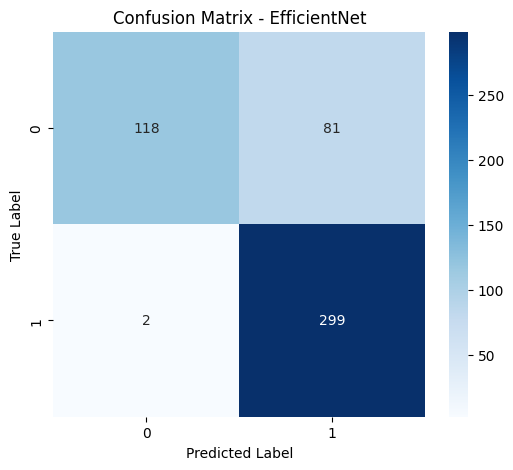

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

def get_true_labels(dataset):
    """Extracts true labels from a TensorFlow dataset."""
    y_true = []
    for images, labels in dataset:  # Unpacking dataset
        y_true.extend(labels.numpy())  # Convert to NumPy array
    return np.array(y_true)

def evaluate_model(model, test_data, model_name):
    """Evaluate the model and display performance metrics."""

    # Get true labels
    y_true = get_true_labels(test_data)

    # Predict class probabilities
    y_pred_probs = model.predict(test_data)

    # Convert probabilities to class labels (Threshold = 0.5)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print Accuracy, Precision, Recall, F1-score
    print(f"\n📊 Performance Metrics for {model_name}:")
    print(classification_report(y_true, y_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Evaluate both models
evaluate_model(cnn_model, test_data, "Hard-Coded CNN")
evaluate_model(model, test_data, "EfficientNet")
